<a id='beginning'></a>
# Исследование надёжности заёмщиков

**Ход исследования**

 1. [Изучение общей информации о данных.](#data_learning)
 2. [Предобработка данных.](#data_preprocessing)
    - [Заполнение пропусков](#filling_gaps)
    - [Проверка данных на аномалии и исправления.](#data_verification)
    - [Изменение типов данных.](#changing_types)
    - [Удаление дубликатов](#removing_duplicates)
    - [Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.](#decomposition)
    - [Категоризация дохода.](#categorization_income)
    - [Категоризация целей кредита.](#categorization_loan)
 4. [Ответы на вопросы.](#problem_solution)
 5. [Общий вывод.](#conclusion)

<a id='data_learning'></a>
## Изучение общей информации о данных
Составим первое представление о данных, предоставленных заказчиком.

In [1]:
# импорт библиотеки pandas
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

# чтение файла с данными и сохранение в df
df = pd.read_csv('./datasets/data.csv')

# вывод данных
display(df)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [2]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
# просмотр количества уникальных значений
print(df.nunique())

children                8
days_employed       19351
dob_years              58
education              15
education_id            5
family_status           5
family_status_id        5
gender                  3
income_type             8
debt                    2
total_income        19351
purpose                38
dtype: int64


Итак, в таблице 12 (двенадцать) столбцов и 21525 строк.
В таблице представлены следующие типы данных: float64(2 поля), int64(5 полей), object(5 полей)

Согласно документации к данным:
* `children` —  количество детей в семье - количественные данные;
* `days_employed` — общий трудовой стаж в днях - количественные данные;
* `dob_years` — возраст клиента в годах - категориальные данные;
* `education` — уровень образования клиента - категориальные данные;
* `education_id` — идентификатор уровня образования - категориальные данные;
* `family_status` — семейное положение - категориальные данные;
* `family_status_id` — идентификатор семейного положения - категориальные данные;
* `gender` - пол клиента - категориальные данные;
* `income_type` - тип занятости - категориальные данные;
* `debt` - имел ли задолженность по возврату кредита - категориальные данные;
* `total_income` - ежемесячный доход - количественные данные;
* `purpose` - цель получения кредита - категориальные данные.

В данных с первого взгляда обнаруживаются следующие артефакты:
1. Количество значений в столбцах различается - поля: `days_employed` (общий трудовой стаж), `total_income` (ежемесячный доход) имеют меньшие значения. Значит, в данных есть пропущенные значения.
2. В поле `days_employed` (общий трудовой стаж в днях) встречаются отрицательные значения.
3. Просмотр уникальных значений выявил логическое несоответствие в полях: `education` (уровень образования), `education_id` (идентификатор уровня образования), `gender` (пол клиента). Вероятно в этих столбцах присутствуют артефакты.
4. Поля `total_income` (ежемесячный доход) и `days_employed` (общий трудовой стаж) представлены вещественными числами.
5. Поле `purpose` (цель получения кредита) имеет неявные дупликаты - трактование единого смысла разными фразами, например: "сделка с автомобилем", "приобретение автомобиля".

**Вывод**

Предварительно можно утверждать, что, данных достаточно для выявления влияния количества детей в семье и семейного положения на факт погашения кредита в срок. Однако встречаются пропуски в данных и некоторые значения не соотвествуют логике жизни.

**Навигация**
* [Начало](#beginning)
* [Изучение общей информации о данных.](#data_learning)
* [Ответы на вопросы.](#problem_solution)
* [Общий вывод.](#conclusion)

<a id='data_preprocessing'></a>
## Предобработка данных

   - [Заполнение пропусков](#filling_gaps)
   - [Проверка данных на аномалии и исправления.](#data_verification)
   - [Изменение типов данных.](#changing_types)
   - [Удаление дубликатов](#removing_duplicates)
   - [Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.](#decomposition)
   - [Категоризация дохода.](#categorization_income)
   - [Категоризация целей кредита.](#categorization_loan)

<a id='filling_gaps'></a>
### Заполнение пропусков
Предварительное ознакомление с данными выявило два поля: `days_employed`, `total_income`, значения которых 19351 проитив общего значения 21525. Проверим наше предположение о наличии пропусков в этих столбцах.

In [4]:
# подсчёт количества пропущенных значений по каждому полю (столбцу)
print('Количество пропусков:', df.isna().sum(), sep='\n')

Количество пропусков:
children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


- Проверка выявила наличие пропусков в полях: `days_employed`, `total_income` в количестве 2174.
- В каждом поле пропуски составляют 10% от общего количества, что является критичным фактом для последующего анализа.
- Возможная причина пропусков - отсутствие этой информации в анкете клиента: ошибка оператора, технологическая ошибка записи.
- Заполним пропущенные данные медианными значениями, поскольку во-первых, данные количественные, во-вторых, медиана более устойчивая к аномальным выбросам, которые могут значительно исказить картину в случае использования среднего арифметического.

Прежде заполнения пропусков изучим значения полей с пропусками
##### Проверим экстремумы поля "общий трудовой стаж".

In [5]:
df['days_employed'].max()

401755.40047533

In [6]:
df['days_employed'].min()

-18388.949900568383

Учитывая, что поле содержит значения общего струдового стажа в днях, получается, что максимальное значение равно 1101 году... Это явный абсурд. По трудовому законодательству РФ нижний возрастной порог трудовой деятельности 14 лет. Верхний возрастной порог согласно наших данных 75 лет, следовательно максимальный трудовой стаж клиента составляет 61 год, что составляет 22265 дней.
Выполним замену отрицательных значений на положительные.

In [7]:
# приведем все значения поля "общий трудовой стаж клиента" к положительным значениям
df['days_employed'] = df['days_employed'].abs()

# проверим выполненные изменения, выведем первые строки таблицs, они изначально имели отрицательные значения
display(df.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Проверим минимальное значение трудового стажа клиента

In [8]:
df['days_employed'].min()

24.14163324048118

Для корректного рассчета медианы сначала обнулим значения, превышающие значение максимального трудового стажа

In [9]:
df.loc[df['days_employed'] > 22265, 'days_employed'] = 0

Рассчитаем медианное значение для полей: `total_income`, `days_employed` и выполним замену пропусков и нулевых значений на медианное значение.

In [10]:
# рассчитаем медианное значение для каждого столбца
total_income_mediane = df['total_income'].median()
days_employed_mediane = df['days_employed'].median()
print('Медиана ежемесячного дохода =', total_income_mediane)
print('Медиана общего трудового стажа =', days_employed_mediane)
print()

# заполним пропуски медианными значениями
df['days_employed'] = df['days_employed'].fillna(days_employed_mediane)
df['total_income'] = df['total_income'].fillna(total_income_mediane)

# выполним замену нулевых значений на медианное значение
df.loc[df['days_employed'] == 0, 'days_employed'] = days_employed_mediane

# выполним проверку на наличие пропущенных значений
print('Количество пропусков:', df.isna().sum(), sep='\n')

Медиана ежемесячного дохода = 145017.93753253992
Медиана общего трудового стажа = 1203.369528770489

Количество пропусков:
children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


* [Начало](#beginning)
* [Предобработка данных.](#data_preprocessing)
* [Заполнение пропусков](#filling_gaps)

<a id='data_verification'></a>
### Проверка данных на аномалии и исправления.
На этапе общего изучения информации о данных были выявлены аномалии:
- поле "общего трудового стажа" имеет ряд отрицательных значений;
- поле "пол клиента" имеет 3 уникальных значения;
- поле "уровень образования клиента" имеет 15 уникальных значений, а поле "идентификатор уровня образования" имеет 5 уникальных значений.

Приступим к выявлению и исправлению этих аномалий.

In [11]:
# выведем частоту уникальных значений поля "пол клиента"
print('Частота уникальных значений:', df['gender'].value_counts(), sep='\n')

Частота уникальных значений:
F      14236
M       7288
XNA        1
Name: gender, dtype: int64


Поле "пол клиента" содержит всего одно неопределенное значение XNA. На общую аналитическую картину этот артефакт влияние не окажет. Для наглядности выполним замену этого значения на более понятное 'unknown'

In [12]:
# выполним замену неопределенного значения в поле "пол клиента"
df.loc[df['gender'] == 'XNA', 'gender'] = 'unknown'

# проверим выполненную замену, выведем частоту уникальных значений поля "пол клиента"
print('Частота уникальных значений:', df['gender'].value_counts(), sep='\n')

Частота уникальных значений:
F          14236
M           7288
unknown        1
Name: gender, dtype: int64


In [13]:
# выведем количество уникальных значений и частоту уникальных значений поля "уровень образования клиента"
print('Количество уникальных значений =', df['education'].nunique())
print('Частота уникальных значений:', df['education'].value_counts(), sep='\n')

Количество уникальных значений = 15
Частота уникальных значений:
среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64


Как видно, это поле имеет неявные дупликаты, как мы и предполагали, связанные с разным форматом написания. Займемся их устранением позже.

In [14]:
# выведем количество уникальных значений и частоту уникальных значений поля "цель получения кредита"
print('Количество уникальных значений =', df['purpose'].nunique())
print('Частота уникальных значений:', df['purpose'].value_counts(), sep='\n')

Количество уникальных значений = 38
Частота уникальных значений:
свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку свое

Как видно, это поле также имеет достаточное количество неявных дупликатов, трактующих по разному одинаковый смысл. Формат написания одинаковый. Займемся их устранением позже.

##### Проверим уникальные значения поля "дети".

In [15]:
print(df['children'].value_counts())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64


Среди уникальных значений есть отрицательное значение -1, которое встречается 47 раз и значение 20, которое встречается 76 раз. Это похоже на ошибку оператора.

In [16]:
# выполним замену значения -1 на 1, а значение 20 на 2 в поле "дети"
df.loc[df['children'] == -1, 'children'] = 1
df.loc[df['children'] == 20, 'children'] = 2

# проверим выполненные замены
print(df['children'].value_counts())

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64


##### Проверим экстремумы значений поля "возраст клиента"

In [17]:
df['dob_years'].max()

75

In [18]:
df['dob_years'].min()

0

In [19]:
df[df['dob_years'] == 0]['dob_years'].count()

101

Минимальный возраст клиента 0 и это значение встечается 101 раз.  Явный артефакт, заменим его на среднее значение возраста клиента.

In [20]:
# определим средний возраст клиента
mean_age = df['dob_years'].mean()

# выполним замену нулевых значений на среднее
df.loc[df['dob_years'] == 0, 'dob_years'] = mean_age

# выполним проверку
df['dob_years'].min()

19.0

Минимальный возраст заемщика 19 лет, это соотвествует законодательству РФ (минимальный возраст кредитования гражданина РФ 18 лет)
Тип значений поля "возраст клиента" изменился на вещественный. Изменим его на целочисленный позже.

* [Начало](#beginning)
* [Предобработка данных.](#data_preprocessing)
* [Проверка данных на аномалии и исправления.](#data_verification)

<a id='changing_types'></a>
### Изменение типов данных.

In [21]:
# изменим тип данных в поле "общий трудовой стаж" с вещественного на целочисленный
df['days_employed'] = df['days_employed'].astype('int64')
# изменим тип данных в поле "ежемесячный доход" с вещественного на целочисленный
df['total_income'] = df['total_income'].astype('int64')
# изменим тип данных в поле "возраст клиента" с вещественного на целочисленный
df['dob_years'] = df['dob_years'].astype('int64')

# проверим внесенные изменения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


* [Начало](#beginning)
* [Предобработка данных.](#data_preprocessing)
* [Изменение типов данных.](#changing_types)

<a id='removing_duplicates'></a>
### Удаление дубликатов.
Сначала выясним наличие явных дупликатов и при их наличии удалим стандартным методом drop_duplicates()

In [22]:
# сначала приведем все текстовые данные к нижнему регистру
df['education'] = df['education'].str.lower()
df['family_status'] = df['family_status'].str.lower()
df['gender'] = df['gender'].str.lower()
df['income_type'] = df['income_type'].str.lower()
df['purpose'] = df['purpose'].str.lower()

# подсчёт количества явных дубликатов
df.duplicated().sum()

71

In [23]:
# удаление явных дупликатов
df = df.drop_duplicates().reset_index(drop=True)

# проверим результат удаления явных дубликатов
df.duplicated().sum()

0

Теперь займемся неявными дупликатами, появление которых чаще всего связано с человеческим фактором - ошибкой написания. На этапе проверки данных на аномалии мы выяснили, что поле `education` (уровень образования) содержит ряд дупликатов, которые отличаются различным стилем форматирования.

##### Проверим поле "уровень образования" на количество и частоту уникальных значений

In [24]:
# проверим поле "уровень образования" на количество и частоту уникальных значений
print('Количество уникальных значений =', df['education'].nunique())
print('Частота уникальных значений:',df['education'].value_counts(), sep='\n')

Количество уникальных значений = 5
Частота уникальных значений:
среднее                15172
высшее                  5250
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64


Как видим, после приведения к нижнему регистру количество уникальных значений в поле "уровень образования", сократилось с 15 до 5 и стало соотвествовать количеству уникальных значений поля "идентификатор уровня образования".

##### Проверим поле "семейное положение" на частоту уникальных значений и формат

In [25]:
print('Частота уникальных значений:',df['family_status'].value_counts(), sep='\n')

Частота уникальных значений:
женат / замужем          12339
гражданский брак          4151
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64


В поле "семейное положение" артефактов не выявлено.

##### Проверим поле "тип занятости" на частоту уникальных значений и формат

In [26]:
print('Количество уникальных значений =', df['income_type'].nunique())
print('Частота уникальных значений:',df['income_type'].value_counts(), sep='\n')

Количество уникальных значений = 8
Частота уникальных значений:
сотрудник          11084
компаньон           5078
пенсионер           3829
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64


В поле "тип занятости" артефакты не выявлены.

* [Начало](#beginning)
* [Предобработка данных.](#data_preprocessing)
* [Удаление дубликатов](#removing_duplicates)

<a id='decomposition'></a>
### Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [27]:
# Создаем два новых датафрейма (словари):
# словарь "Образование"
df_1 = df[['education_id','education']]
# словарь "Семейное положение"
df_2 = df[['family_status_id','family_status']]

print(df_1.head(2))
print(df_2.head(2))

   education_id education
0             0    высшее
1             1   среднее
   family_status_id    family_status
0                 0  женат / замужем
1                 0  женат / замужем


In [28]:
# Удалим из исходного датафрейма столбцы education и family_status
df = df.drop(columns=['education', 'family_status'])
display(df.head())

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,0,0,f,сотрудник,0,253875,покупка жилья
1,1,4024,36,1,0,f,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,1,0,m,сотрудник,0,145885,покупка жилья
3,3,4124,32,1,0,m,сотрудник,0,267628,дополнительное образование
4,0,1203,53,1,1,f,пенсионер,0,158616,сыграть свадьбу


* [Начало](#beginning)
* [Предобработка данных.](#data_preprocessing)
* [Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.](#decomposition)

<a id='categorization_income'></a>
### Категоризация дохода.

In [29]:
"""
    Функция income_group() возвращает категорию клиента по значению ежемесячного дохода total_income, используя правила:
    0–30000 — 'E';
    30001–50000 — 'D';
    50001–200000 — 'C';
    200001–1000000 — 'B';
    1000001 и выше — 'A'.
"""

def income_group(income):

    if income <= 30000:
        return 'E'
    if 30001 <= income <= 50000:
        return 'D'
    if 50001 <= income <= 200000:
        return 'C'
    if 200000 <= income <= 1000000:
        return 'B'
    if 1000001 <= income:
        return 'A'

# создаем столбец в исходном датафрейме с категориями клиента по ежемесячному доходу.
# новый столбец располагаем в конкретном месте, следом за столбцом total_income, для этого используем метод insert()
df.insert(9, "total_income_category", df['total_income'].apply(income_group))
display(df.head())

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,total_income_category,purpose
0,1,8437,42,0,0,f,сотрудник,0,253875,B,покупка жилья
1,1,4024,36,1,0,f,сотрудник,0,112080,C,приобретение автомобиля
2,0,5623,33,1,0,m,сотрудник,0,145885,C,покупка жилья
3,3,4124,32,1,0,m,сотрудник,0,267628,B,дополнительное образование
4,0,1203,53,1,1,f,пенсионер,0,158616,C,сыграть свадьбу


* [Начало](#beginning)
* [Предобработка данных.](#data_preprocessing)
* [Категоризация дохода.](#categorization_income)

<a id='categorization_loan'></a>
### Категоризация целей
Функция `purpose_group(str)`, принимает на вход строку серии, а возвращает измененную строку, согласно нашего списка категорий:
- проведение свадьбы;
- операции с автомобилем;
- операции с недвижимостью;
- получение образования.

In [30]:
def purpose_group(str):
    str_list = str.split()
    for word in str_list:
        if 'свадьб' in word:
            return 'проведение свадьбы'
        if 'автомобил' in word:
            return 'операции с автомобилем'
        if 'недвижимост' in word or 'жил' in word:
            return 'операции с недвижимостью'
        if 'образован' in word:
            return 'получение образования'

# в исходном датафрейме создаем столбец с категориями целей получения кредита.
df['purpose_category'] = df['purpose'].apply(purpose_group)
display(df.head())

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,total_income_category,purpose,purpose_category
0,1,8437,42,0,0,f,сотрудник,0,253875,B,покупка жилья,операции с недвижимостью
1,1,4024,36,1,0,f,сотрудник,0,112080,C,приобретение автомобиля,операции с автомобилем
2,0,5623,33,1,0,m,сотрудник,0,145885,C,покупка жилья,операции с недвижимостью
3,3,4124,32,1,0,m,сотрудник,0,267628,B,дополнительное образование,получение образования
4,0,1203,53,1,1,f,пенсионер,0,158616,C,сыграть свадьбу,проведение свадьбы


**Вывод**

После предобработки данных наш датафрейм значительно изменился. Количество строк уменьшилось на 0,3%. Это не существенно для дальнейшего анализа. Можно считать, что объем данных в результате предобработки сохранен.

**Навигация**
* [Начало](#beginning)
* [Изучение общей информации о данных.](#data_learning)
* [Предобработка данных.](#data_preprocessing)
    - [Заполнение пропусков](#filling_gaps)
    - [Проверка данных на аномалии и исправления.](#data_verification)
    - [Изменение типов данных.](#changing_types)
    - [Удаление дубликатов](#removing_duplicates)
    - [Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.](#decomposition)
    - [Категоризация дохода.](#categorization_income)
    - [Категоризация целей кредита.](#categorization_loan)
* [Общий вывод.](#conclusion)

<a id='problem_solution'></a>
## Ответы на вопросы

##### Вопрос: Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [31]:
# выведим зависимость возврата кредита в срок от количества детей в семье
children_debt = df.groupby('children', as_index=False)['debt'].sum()
print(children_debt)

   children  debt
0         0  1063
1         1   445
2         2   202
3         3    27
4         4     4
5         5     0


<AxesSubplot:xlabel='children', ylabel='debt'>

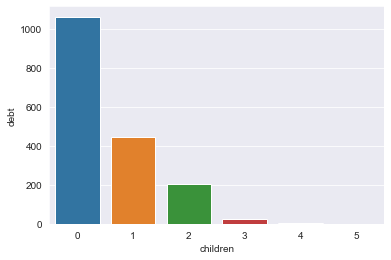

In [32]:
# построим график зависимости
sns.barplot(x=children_debt['children'], y=children_debt['debt'], data=children_debt)

##### Ответ
Возврат кредита в срок имеет прямую зависимость от количества детей в семье. Чем больше детей в семье, тем большую финансовую дисциплину демонстрирует клиент. Многодетные семьи демонстрируют самую высокую финансовую дисциплину.

##### Вопрос: Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [33]:
# выведим категории семейного положения
print(*df_2['family_status'].unique(), sep='\n')

женат / замужем
гражданский брак
вдовец / вдова
в разводе
не женат / не замужем


<AxesSubplot:xlabel='family_status_id', ylabel='debt'>

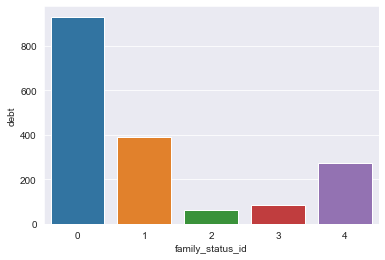

In [34]:
# определим зависимость возврата кредита в срок от семейного положения
famely_debt = df.groupby('family_status_id')['debt'].sum()
# склеим две таблицы по внешнему ключу family_status_id
data_final = df_2.merge(famely_debt, on='family_status_id', how='left')
# построим график зависимости
sns.barplot(x=data_final['family_status_id'], y=data_final['debt'], data=data_final)

##### Ответ
Мы видим, что совместное проживание негативно сказывается на финансовую дисциплину. Лидируют в нарушении сроков возврата кредита клиенты, состоящие в официальном браке. За ними следую клиенты состоящие в гражданском браке. Наиболее дисциплинированы клиенты из категории "вдовец / вдова".

##### Вопрос: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Категории клиентов от уровня дохода:
* 0–30000 —  E
* 30001–50000 — D
* 50001–200000 — C
* 200001–1000000 — B
* 1000001 и выше — A

In [35]:
# Выведим зависимость возврата кредита в срок от уровня ежемесячного дохода
total_income_category_debt = df.groupby('total_income_category', as_index=False)['debt'].sum()
print(total_income_category_debt)

  total_income_category  debt
0                     A     2
1                     B   356
2                     C  1360
3                     D    21
4                     E     2


<AxesSubplot:xlabel='total_income_category', ylabel='debt'>

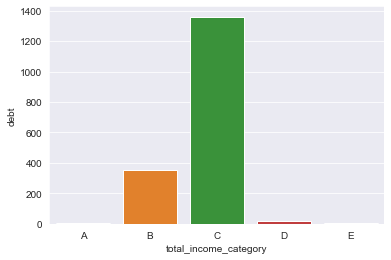

In [36]:
# построим график зависимости
sns.barplot(x=total_income_category_debt['total_income_category'], y=total_income_category_debt['debt'], data=total_income_category_debt)

##### Ответ
Наиболее высокая финансовая дисциплина у клиентов двух противоположных категорий: низкий доход и сверхвысокий доход.
Самая низкая финансовая дисциплина у клиентов средней категории с доходом 50001 - 200000 руб.
Клиенты, имеющие доход выше среднего демонстрируют более высокую финансовую дисциплину.

##### Вопрос: Как разные цели кредита влияют на его возврат в срок?

In [37]:
# выведим зависимость возврата кредита в срок от цели получения кредита
purpose_category_debt = df.groupby('purpose_category', as_index=False)['debt'].sum()
print(purpose_category_debt)

           purpose_category  debt
0    операции с автомобилем   403
1  операции с недвижимостью   782
2     получение образования   370
3        проведение свадьбы   186


(array([0, 1, 2, 3]),
 [Text(0, 0, 'операции с автомобилем'),
  Text(1, 0, 'операции с недвижимостью'),
  Text(2, 0, 'получение образования'),
  Text(3, 0, 'проведение свадьбы')])

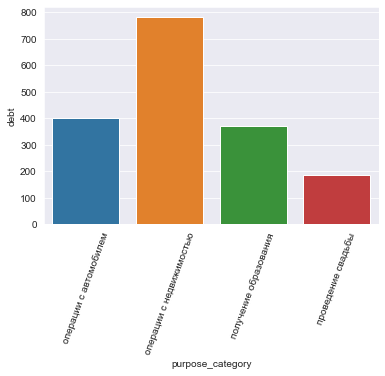

In [38]:
# построим график зависимости
sns.barplot(x=purpose_category_debt['purpose_category'], y=purpose_category_debt['debt'], data=purpose_category_debt)
plt.xticks(rotation=70)

##### Ответ
Ярко выраженной тенденции нет.
Самая низкая финансовая дисциплина у клиентов, кредитуемых на операции с недвижимостью. Как правило, это долгосрочные кредиты, жизненная ситуация клиента может изменится не в лучшую сторону, а следовательно может изменится платежеспособность по своим обязательствам.
Самая высокая финансовая дисциплина у клиентов, кредитуемых на проведение свадьбы. Кредиты краткосрочные, и, как правило, погашаются за счет подаренных средств на свадьбу.

**Навигация**
* [Начало](#beginning)
* [Изучение общей информации о данных.](#data_learning)
* [Предобработка данных.](#data_preprocessing)
    - [Заполнение пропусков](#filling_gaps)
    - [Проверка данных на аномалии и исправления.](#data_verification)
    - [Изменение типов данных.](#changing_types)
    - [Удаление дубликатов](#removing_duplicates)
    - [Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.](#decomposition)
    - [Категоризация дохода.](#categorization_income)
    - [Категоризация целей кредита.](#categorization_loan)
* [Ответы на вопросы.](#problem_solution)

<a id='conclusion'></a>
## Общий вывод
##### В итоге можно нарисовать словесный портрет идеального клиента для кредитования.
Для любых суммы кредита, срока кредита, ежемесячного платежа:
1. Вдова / вдовец
2. Сверхвысокий доход
3. Количество детей более 3

Для целевых кредитов:
1. Семейный
2. Многодетный
3. Стабильный доход до 30000